In [4]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score

In [5]:
# URL del archivo en el bucket público de AWS
url = "https://hybridge-education-machine-learning-datasets.s3.us-east-1.amazonaws.com/Fraud.csv"
df = pd.read_csv(url)

In [6]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
len(df)

6362620

# ¡¡¡6,362,620 OBSERVACIONES!!!

Dado el tamaño del conjunto de datos, usaremos una muestra para entrenar el modelo en un tiempo razonable.

## 1. Exploración de datos (EDA)

In [8]:
# Información general del dataset
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            str    
 2   amount          float64
 3   nameOrig        str    
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        str    
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), str(3)
memory usage: 534.0 MB


In [9]:
# Estadísticas descriptivas de las variables numéricas
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Conteo por clase (isFraud):
isFraud
0    6354407
1       8213
Name: count, dtype: int64

Proporción:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


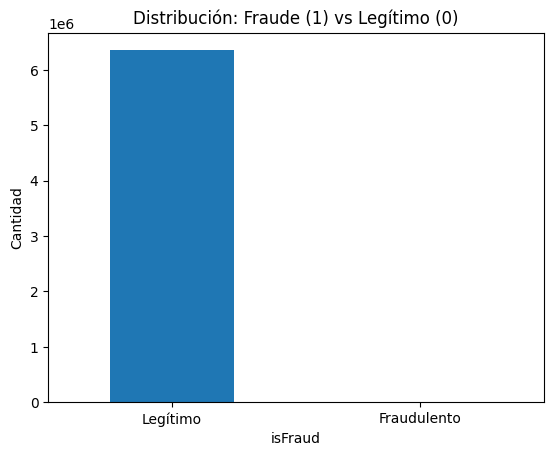

In [10]:
# Distribución de la variable objetivo: transacciones fraudulentas vs legítimas
print("Conteo por clase (isFraud):")
print(df['isFraud'].value_counts())
print("\nProporción:")
print(df['isFraud'].value_counts(normalize=True))
df['isFraud'].value_counts().plot(kind='bar', title='Distribución: Fraude (1) vs Legítimo (0)')
plt.xlabel('isFraud')
plt.ylabel('Cantidad')
plt.xticks([0, 1], ['Legítimo', 'Fraudulento'], rotation=0)
plt.show()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


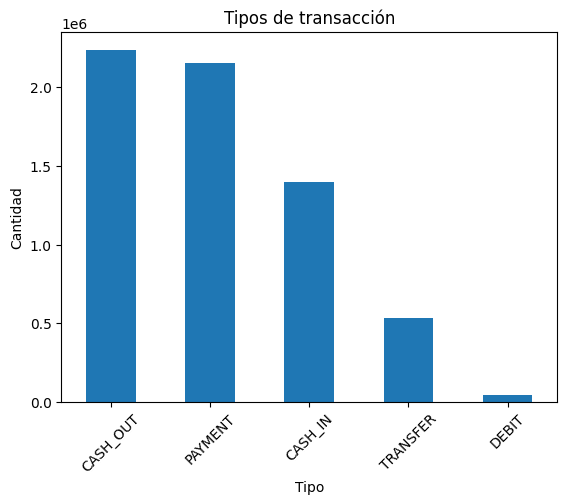

In [11]:
# Tipos de transacción
print(df['type'].value_counts())
df['type'].value_counts().plot(kind='bar', title='Tipos de transacción')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Valores faltantes
print("Valores faltantes por columna:")
print(df.isnull().sum())

Valores faltantes por columna:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


## 2. Preprocesamiento

Se toma una muestra estratificada para mantener la proporción de fraudes y reducir el tiempo de entrenamiento. Se eliminan identificadores y se codifica la variable categórica `type`.

In [13]:
# Muestra aleatoria para entrenamiento en tiempo razonable (200k observaciones)
np.random.seed(42)
sample_size = 200_000
df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)
print(f"Muestra utilizada: {len(df_sample)} observaciones")
print("Distribución de isFraud en la muestra:")
print(df_sample['isFraud'].value_counts(normalize=True))

Muestra utilizada: 200000 observaciones
Distribución de isFraud en la muestra:
isFraud
0    0.99866
1    0.00134
Name: proportion, dtype: float64


In [14]:
# Codificación de la variable categórica 'type' (one-hot encoding)
df_processed = pd.get_dummies(df_sample, columns=['type'], drop_first=False)
# Eliminar columnas que no son características: identificadores y etiqueta auxiliar
cols_drop = ['nameOrig', 'nameDest', 'isFlaggedFraud']
df_processed = df_processed.drop(columns=[c for c in cols_drop if c in df_processed.columns], errors='ignore')
df_processed.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
3737323,278,330218.42,20866.00,351084.42,452419.57,122201.15,0,True,False,False,False,False
264914,15,11647.08,30370.00,18722.92,0.00,0.00,0,False,False,False,True,False
85647,10,152264.21,106589.00,258853.21,201303.01,49038.80,0,True,False,False,False,False
5899326,403,1551760.63,0.00,0.00,3198359.45,4750120.08,0,False,False,False,False,True
2544263,206,78172.30,2921331.58,2999503.88,415821.90,337649.60,0,True,False,False,False,False


In [15]:
# Definir características (X) y variable objetivo (y)
target = 'isFraud'
X = df_processed.drop(columns=[target])
y = df_processed[target]
# División entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Entrenamiento: {X_train.shape[0]} | Prueba: {X_test.shape[0]}")

Entrenamiento: 160000 | Prueba: 40000


In [16]:
# Normalización de características con StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Preprocesamiento completado. Dimensiones X_train_scaled:", X_train_scaled.shape)

Preprocesamiento completado. Dimensiones X_train_scaled: (160000, 11)


## 3. Entrenamiento del modelo

Se entrena un modelo de regresión logística con los datos escalados.

In [17]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)
print("Modelo de regresión logística entrenado.")

Modelo de regresión logística entrenado.


## 4. Evaluación del modelo

Se evalúa el desempeño con precisión, recall, reporte de clasificación y matriz de confusión.

In [18]:
y_pred = model.predict(X_test_scaled)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
print("=== MÉTRICAS DE EVALUACIÓN ===\n")
print(f"Precisión (precision): {precision:.4f}")
print(f"Recall (exhaustividad): {recall:.4f}\n")
print("--- Reporte de clasificación ---")
print(classification_report(y_test, y_pred, target_names=['Legítimo', 'Fraudulento']))

=== MÉTRICAS DE EVALUACIÓN ===

Precisión (precision): 1.0000
Recall (exhaustividad): 0.2778

--- Reporte de clasificación ---
              precision    recall  f1-score   support

    Legítimo       1.00      1.00      1.00     39946
 Fraudulento       1.00      0.28      0.43        54

    accuracy                           1.00     40000
   macro avg       1.00      0.64      0.72     40000
weighted avg       1.00      1.00      1.00     40000



Matriz de confusión:
[[39946     0]
 [   39    15]]


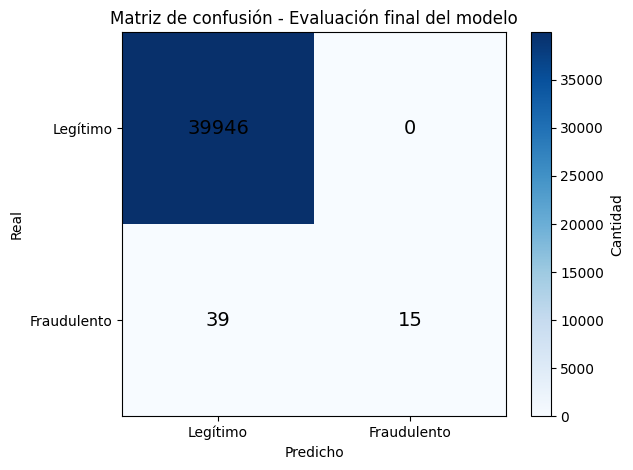

In [19]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(cm)
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Legítimo', 'Fraudulento'])
ax.set_yticklabels(['Legítimo', 'Fraudulento'])
ax.set_ylabel('Real')
ax.set_xlabel('Predicho')
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(cm[i, j]), ha='center', va='center', color='black', fontsize=14)
plt.colorbar(im, ax=ax, label='Cantidad')
plt.title('Matriz de confusión - Evaluación final del modelo')
plt.tight_layout()
plt.show()